In [7]:
%%capture
!pip install remotezip tqdm opencv-python==4.5.2.52 opencv-python-headless==4.5.2.52 tf-models-official
!pip install remotezip

!pip install tf-models-official
!pip install -q mediapy

In [3]:
!pip install numpy==1.26.4 seaborn==0.13.2 matplotlib==3.8.4 scikit-learn==1.5.1 --force-reinstall

  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.8.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached scikit_learn-1.5.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached pandas-2.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
  Using cached contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.59.2-cp312-cp312-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl.metadata (109 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.3 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cache

In [13]:
import tqdm
import random
import pathlib
import itertools
import collections
from glob import glob
import os

import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split

from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model

import mediapy as media

In [14]:
class_names = sorted(os.listdir("/content/drive/MyDrive/data"))
NUM_CLASSES = len(class_names)
class_names

['Abuse',
 'Arrest',
 'Arson',
 'Assault',
 'Burglary',
 'Explosion',
 'Fighting',
 'Normal',
 'RoadAccidents',
 'Robbery',
 'Shooting',
 'Shoplifting',
 'Stealing',
 'Vandalism']

In [15]:
{name: idx for idx, name in enumerate(class_names)}

{'Abuse': 0,
 'Arrest': 1,
 'Arson': 2,
 'Assault': 3,
 'Burglary': 4,
 'Explosion': 5,
 'Fighting': 6,
 'Normal': 7,
 'RoadAccidents': 8,
 'Robbery': 9,
 'Shooting': 10,
 'Shoplifting': 11,
 'Stealing': 12,
 'Vandalism': 13}

In [16]:
def augment(frames):
  # frames = tf.image.convert_image_dtype(frames, tf.float32)
  frames = tf.image.resize_with_crop_or_pad(frames, 224, 224)
  # frames = tf.image.random_crop(frames, [224, 224, 3])
  # frames = tf.image.random_flip_left_right(frames)
  frames = tf.image.random_brightness(frames, max_delta=0.15)
  return frames

In [17]:
class FrameGenerator:
  def __init__(self, video_paths, num_frames, training=False):
    self.video_paths = video_paths
    self.num_frames = num_frames
    self.training = training
    self.class_names = sorted(os.listdir("/content/drive/MyDrive/data"))
    self.class_indiced = {name: idx for idx, name in enumerate(self.class_names)}

  def __call__(self):
    for path in self.video_paths:
      frames = self._load_video(path)
      label = self._get_label(path)

      yield frames, label

  def _load_video(self, path):
    """extracting num_frames from video"""
    cap = cv2.VideoCapture(path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames < self.num_frames:
      # looping video if too short
      frame_indices = list(range(total_frames)) * (self.num_frames // total_frames + 1)
      frame_indices = frame_indices[:self.num_frames]
    else:
      frame_indices = sorted(random.sample(range(total_frames), self.num_frames))

    frames = []
    for idx in frame_indices:
      cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
      ret, frame = cap.read()

      if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (224, 224))

        frame = augment(frame)

        frames.append(frame)
    cap.release()

    return tf.convert_to_tensor(frames, dtype=tf.float32) / 255.0

  def _get_label(self, path):
    class_name = os.path.basename(os.path.dirname(path))
    return self.class_indiced[class_name]


In [18]:
video_paths = glob("/content/drive/MyDrive/data/*/*")

train_paths, test_paths = train_test_split(
    video_paths,
    test_size=0.3,
    random_state=42,
    stratify=[
        os.path.basename(os.path.dirname(path)) for path in video_paths
    ]
)
val_paths, test_paths = train_test_split(
    test_paths,
    test_size=0.3,
    random_state=42,
    stratify=[
        os.path.basename(os.path.dirname(path)) for path in test_paths
    ]
)

subset_paths = {
    "train": train_paths,
    "val": val_paths,
    "test": test_paths
}

In [19]:
batch_size = 8
num_frames = 16

video_paths = glob("/content/drive/MyDrive/data/*/*")

output_signature = (
    tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(), dtype=tf.int16)
)

train_ds = tf.data.Dataset.from_generator(
    FrameGenerator(subset_paths['train'], num_frames, training=True),
    output_signature=output_signature
).batch(batch_size)

val_ds = tf.data.Dataset.from_generator(
    FrameGenerator(subset_paths['val'], num_frames),
    output_signature=output_signature
).batch(batch_size)

test_ds = tf.data.Dataset.from_generator(
    FrameGenerator(subset_paths['test'], num_frames),
    output_signature=output_signature
).batch(batch_size)



In [20]:
for frames, labels in train_ds.take(NUM_CLASSES):
  print(labels)

tf.Tensor([12  9 11 13  7  8  2  7], shape=(8,), dtype=int16)
tf.Tensor([ 7  7  9 11  7  8  3  1], shape=(8,), dtype=int16)
tf.Tensor([ 9  1  8 10  2  8  9  6], shape=(8,), dtype=int16)
tf.Tensor([ 0  6  4  6  8 12  5  3], shape=(8,), dtype=int16)
tf.Tensor([ 0 10  7  7  8  2  1 12], shape=(8,), dtype=int16)
tf.Tensor([4 7 3 6 9 4 4 5], shape=(8,), dtype=int16)
tf.Tensor([ 9  6  7  6  5  9 10  8], shape=(8,), dtype=int16)
tf.Tensor([ 6 13  4 12  8 12  8  0], shape=(8,), dtype=int16)
tf.Tensor([ 8  7  8  8  2  8 10  1], shape=(8,), dtype=int16)
tf.Tensor([ 7 12  9  5  4  7  1  9], shape=(8,), dtype=int16)
tf.Tensor([12 10  3  0  3  2  0  6], shape=(8,), dtype=int16)
tf.Tensor([8 5 8 9 4 7 7 9], shape=(8,), dtype=int16)
tf.Tensor([ 9  8 12  2  7  8  9 11], shape=(8,), dtype=int16)
tf.Tensor([ 8  8  9  9 13  9 13  8], shape=(8,), dtype=int16)



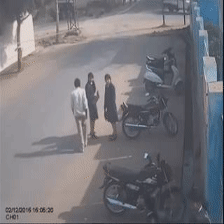
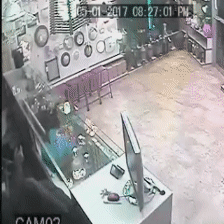
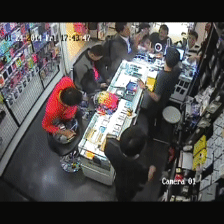
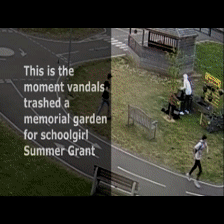
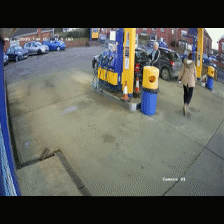
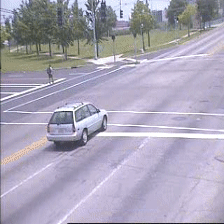
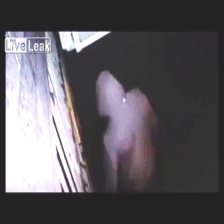
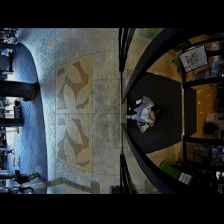

In [21]:
videos, labels = next(iter(train_ds))
media.show_videos(videos.numpy(), codec='gif', fps=30)

In [25]:
model_id = 'a1'
resolution = 224

tf.keras.backend.clear_session()

backbone = movinet.Movinet(
    model_id= model_id
)
backbone.trainable = False

model = movinet_model.MovinetClassifier(
    backbone=backbone,
    num_classes=600, # to load the pretrained weights
)

!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a1_base.tar.gz -O movinet_a1_base.tar.gz -q
!tar -xvf movinet_a1_base.tar.gz

checkpoint_dir = f"/content/movinet_{model_id}_base"
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)

status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()

movinet_a1_base/
movinet_a1_base/checkpoint
movinet_a1_base/ckpt-1.data-00000-of-00001
movinet_a1_base/ckpt-1.index


In [27]:
def build_classifier(batch_size, num_frames, resolution, num_classes):
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes
  )

  model.build([batch_size, num_frames, resolution, resolution, 3])

  return model

In [28]:
batch_size, num_frames, resolution, resolution, NUM_CLASSES

(8, 16, 224, 224, 14)

In [29]:
model = build_classifier(batch_size, num_frames, resolution, NUM_CLASSES)

In [30]:
model.summary()

Model: "movinet_classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, None, None, Non   0         
                             e, 3)]                              
                                                                 
 movinet (Movinet)           ({'stem': (None, None,    2257664   
                             None, None, 16),                    
                              'block0_layer0': (None             
                             , None, None, None, 16)             
                             , 'block0_layer1': (Non             
                             e, None, None, None, 16             
                             ),                                  
                              'block1_layer0': (None             
                             , None, None, None, 40)             
                             , 'block1_layer1'

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="checkpoints/movinet_best.h5",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    mode="max",
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True,
    mode="max",
    verbose=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    min_lr=1e-6,
    mode="min",
    verbose=1
)

callbacks = [checkpoint_cb, earlystop_cb, reduce_lr_cb]

In [31]:
import keras

epochs = 10
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = 'adam'

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [32]:
train_ds, test_ds

(<_BatchDataset element_spec=(TensorSpec(shape=(None, None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int16, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int16, name=None))>)

In [ ]:
results = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs,
    validation_freq=1,
    # callbacks=callbacks,
    verbose=1
)

Epoch 1/10
      1/Unknown - 248s 248s/step - loss: 2.6503 - accuracy: 0.0000e+00

In [ ]:
!pip uninstall -y keras